#Imports

In [ ]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.5/104.5 KB 5.3 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelBinarizer

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import WordNetLemmatizer

from bs4 import BeautifulSoup

import re,string
import contractions

from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.metrics import RocCurveDisplay

import os
import warnings
warnings.filterwarnings('ignore')

#Importing dataset

Dataset info:

This is a dataset for binary sentiment classification. We provide a set of 50,000 highly polar movie reviews for training and testing.

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
df=pd.read_csv('/content/gdrive/MyDrive/LargeMovieReviewDataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.shape

(50000, 2)

So we see that our dataset contains 50000 records and 2 columns: review and sentiment.

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


There are 49582/50000 unique reviews.

In [ ]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

Our dataset is balanced: each target class is represented by the same number of input samples (25000).

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


Is seems there are no null values in the dataset.

#Cleaning and tokenization

Let's take a look at one review from our dataset:

In [ ]:
df['review'][45]

"As a disclaimer, I've seen the movie 5-6 times in the last 15 years, and I only just saw the musical this week. This allowed me to judge the movie without being tainted by what was or wasn't in the musical (however, it tainted me when I watched the musical :) ) <br /><br />I actually believe Michael Douglas worked quite well in that role, along with Kasey. I think her 'Let me dance for you scene' is one of the best parts of the movie, a worthwhile addition compared to the musical. The dancers and singing in the movie are much superior to the musical, as well as the cast which is at least 10 times bigger (easier to do in the movie of course). The decors, lighting, dancing, and singing are also much superior in the movie, which should be expected, and was indeed delivered. <br /><br />The songs that were in common with the musical are better done in the movie, the new ones are quite good ones, and the whole movie just delivers more than the musical in my opinion, especially compared to 

First I'd like to reduce the noise in the data: remove/transform some parts of the text using regular expressions to make the text more understandable for future models. I'll remove html tags, brackets, links, punctuation, etc. Also, since the subject of our research is movie reviews, I'd expect emojis to be there. I'll separate the emojis into positive and negative ones and replace them with the words 'emopos' and 'emoneg' respectively. Since there is informal speech in the text, I will deal with the repetition of letters as well.

In [ ]:
def replace_emoji(text):

  ''' Replacing emojis with words that separate positive and negative ones '''

  # smile -- :), : ), :-), (:, ( :, (-:, :')
  text = re.sub(r'(:\s?\)|:-\)|\(\s?:|\(-:|:\'\))', ' emopos ', text)
  # laugh -- :D, : D, :-D, xD, x-D, XD, X-D
  text = re.sub(r'(:\s?D|:-D|x-?D|X-?D)', ' emopos ', text)
  # love -- <3, :*
  text = re.sub(r'(<3|:\*)', ' emopos ', text)
  # wink -- ;-), ;), ;-D, ;D, (;,  (-;
  text = re.sub(r'(;-?\)|;-?D|\(-?;)', ' emopos ', text)
  # sad -- :-(, : (, :(, ):, )-:
  text = re.sub(r'(:\s?\(|:-\(|\)\s?:|\)-:)', ' emoneg ', text)
  # cry -- :,(, :'(, :"(
  text = re.sub(r'(:,\(|:\'\(|:"\()', ' emoneg ', text)

  return text


def remove_html(text):

  ''' Removing html tags '''

  soup = BeautifulSoup(text, "html.parser")
  return soup.get_text()


def clean_text(text):
  # removing html
  text = remove_html(text)

  # removing square brackets
  text = re.sub('\[[^]]*\]', ' ', text)

  # replacing contractions
  text = contractions.fix(text)

  # replacing emoji
  text = replace_emoji(text)

  # removing links
  text = re.sub('https?://\S+|www\.\S+', ' ', text)

  # removing text in angle brackets
  text = re.sub('<.*?>+', ' ', text)

  # removing punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

  # removing words with digits
  text = re.sub('\w*\d\w*', ' ', text)

  # removing special characters
  text=re.sub('[^a-zA-z0-9\s]',' ',text)

  # replacing more than one space with one space
  text = re.sub(' +', ' ', text)

  # replacing more than 2 letter repetitions with 2 letters
  text = re.sub(r'(.)\1+', r'\1\1', text)

  # converting text to lower case
  text = text.lower()

  return text

Let's apply the function for cleaning the text on review column.

In [ ]:
df['review']=df['review'].apply(clean_text)

In the next step, I'll tokenize the text using `ToktokTokenizer` to break text into chunks and remove the stopwords using `nltk.corpus.stopwords`.

In [ ]:
# Tokenizer
tokenizer=ToktokTokenizer()
# Setting English stopwords
stopword_list=nltk.corpus.stopwords.words('english')

In [ ]:
stop=set(nltk.corpus.stopwords.words('english'))

# Removing the stopwords
def remove_stopwords(text, stop, is_lower_case=False):

    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    filtered_tokens = [token for token in tokens if token not in stop]

    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

# Applying the function
df['review']=df['review'].apply(remove_stopwords, stop=stop)

#Normalisation

Now we should normalize the dataset. We'll perform lemmatization (using `WordNetLemmatizer`) and stemming (using `PorterStemmer`) and look at the results. In order to optimize and reduce the execution time, I'll use data caching (dictionaries `CACHE_LEMS` and `CACHE_STEMS`).

In [ ]:
# Constants
# POS (Parts Of Speech) for: nouns, adjectives, verbs and adverbs
DI_POS_TYPES = {'NN':'n', 'JJ':'a', 'VB':'v', 'RB':'r'}
MIN_STR_LEN = 3
POS_TYPES = list(DI_POS_TYPES.keys())

CACHE_LEMS = {}

# Lemmatizer initialization
lemmatizer = nltk.stem.WordNetLemmatizer()

# Word lemmatization
def lemmatize(word):

  if len(word) >= MIN_STR_LEN:
    if word in CACHE_LEMS:
      return CACHE_LEMS[word]

    pos = nltk.pos_tag([word])[0][1][:2]
    pos2 = 'n'  # set default to noun

    if pos in DI_POS_TYPES:
      pos2 = DI_POS_TYPES[pos]

    lem = lemmatizer.lemmatize(word, pos2)
    CACHE_LEMS[word] = lem
    return lem

  else:
    return word

In [ ]:
CACHE_STEMS = {}

# Stemmer initialization
pstemmer=nltk.porter.PorterStemmer()

# Word stemming
def stemm(word):
    if word in CACHE_STEMS:
      return CACHE_STEMS[word]
    stem = pstemmer.stem(word)
    CACHE_STEMS[word] = stem
    return stem

For further comparison I'll create lists for initial words, words after lemmatization and words after stemming. To speed up the search for words, I'll also create a set of words.

In [ ]:
# Set of words and lists for initial words, lemmatized words and stemmed words
words_set = set()
words = []
lems = []
stems = []


# Text normalization
def normalize(text):
  # lists for keeping the results of lemmatization and stemming
  lems_res = []
  stems_res = []

  for word in text.split():

    lem = lemmatize(word)
    stem = stemm(word)

    lems_res.append(lem)
    stems_res.append(stem)

    if word not in words_set:
      words_set.add(word)
      words.append(word)
      lems.append(lem)
      stems.append(stem)

  return pd.Series([' '.join(stems_res), ' '.join(lems_res)])

# Applying the function
df[['stem', 'lem']] = df['review'].apply(normalize)

Now we can compare the results of stemming and lemmatization.

In [ ]:
wls = pd.DataFrame({'word': words, 'lem':lems, 'stem': stems})
wls.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
word,one,reviewers,mentioned,watching,oz,episode,hooked,right,exactly,happened,first,thing,struck,brutality,unflinching,scenes,violence,set,word,go
lem,one,reviewer,mention,watch,oz,episode,hooked,right,exactly,happen,first,thing,struck,brutality,unflinching,scene,violence,set,word,go
stem,one,review,mention,watch,oz,episod,hook,right,exactli,happen,first,thing,struck,brutal,unflinch,scene,violenc,set,word,go


So we see that stemming removes the last few characters of words, to obtain a shorter form. A a result, we get the base words. In stemming, for some words, it may not give meaningful representation. We can see the words like 'exactli', 'violenc'. Lemmatization takes more time comparing to stemming because it finds meaningful word (when I tried to lemmatize words without caching, it took around 17 minutes while stemming completed in 2 minutes). For example, lemmatization converted the word 'reviewers' into its single form: 'reviewer', and stemming transformed it to the base 'review'.

In [ ]:
wls.describe()

,word,lem,stem
count,100576,100576,100576
unique,100576,84033,70308
top,one,gas,gener
freq,1,7,28


We see that among 100576 unique words in the dataset there are 84033 lemmas and 70308 base words after stemming.

#Labeling

Let's encode the target feature.

In [ ]:
lb=LabelBinarizer()
df['sentiment']=lb.fit_transform(df['sentiment'])

#X and y datasets

Now we can create train and test datasets. I'll use the results of stemming for X datasets since they have fewer unique words.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['stem'], df['sentiment'], test_size=0.2, random_state=42, stratify=df['sentiment'])

#Top words

In [ ]:
# Plotting the most frequent words
def plot_top_frequency(data, count, title):
  # Calculating word frequencies
  all_words = data.str.split(expand=True).unstack().value_counts()
  # Top words visualization
  fig, ax = plt.subplots(figsize=(12, 12))
  sns.barplot(x = all_words.values[:count],
            y = all_words.index.values[:count], ax=ax, orient='h').set(title=title)

  return all_words

Let's visualize top 30 words for positive reviews.

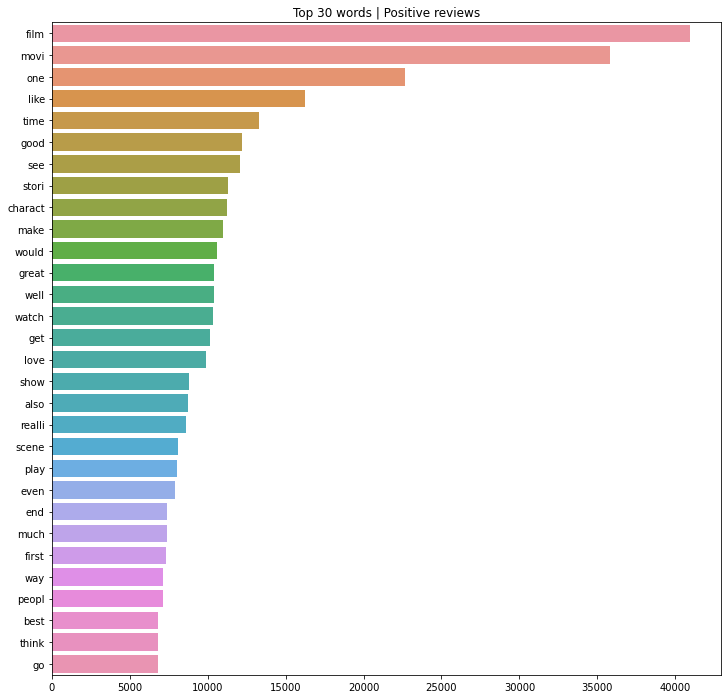

In [ ]:
pos_words = plot_top_frequency(X_train[y_train == 1], 30, 'Top 30 words | Positive reviews')

Now let's take a look at top 30 words for negative reviews.

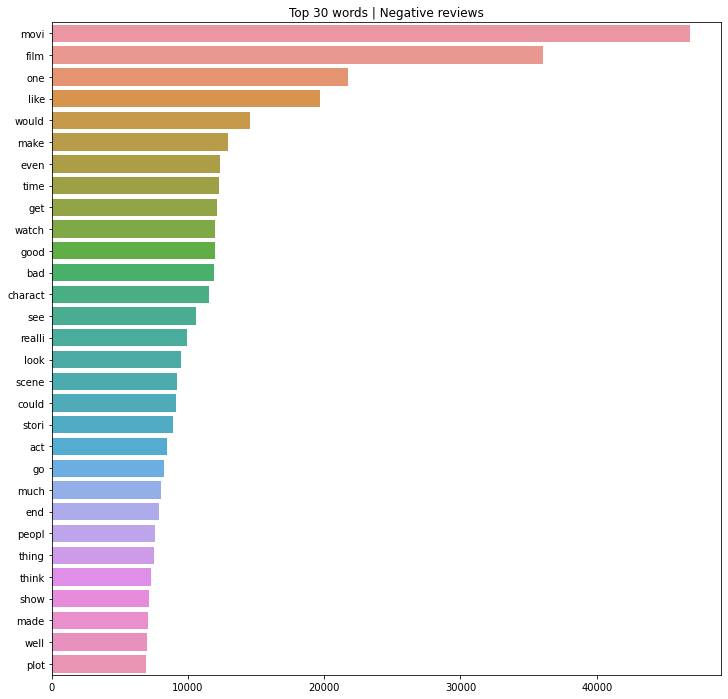

In [ ]:
neg_words = plot_top_frequency(X_train[y_train == 0], 30, 'Top 30 words | Negative reviews')

There are a many words that are popular in both classes, e.g. 'movi', 'film', 'one', 'like'. People seem to use the word 'good' in negative reviews as often as they use the word 'bad'. Although, it seems that peoople use 'movie' more often in the negative class, I can't say all these words are important for classification.

Now I'd like to form the table of word frequencies.

In [ ]:
freq = pd.concat([neg_words, pos_words], axis=1)
freq

,0,1
movi,46816.0,35827.0
film,36087.0,40915.0
one,21776.0,22685.0
like,19717.0,16268.0
would,14525.0,10615.0
...,...,...
touchabl,NaN,1.0
fowzi,NaN,1.0
tabatabai,NaN,1.0
rochfort,NaN,1.0


And vizualize the top 30 words.

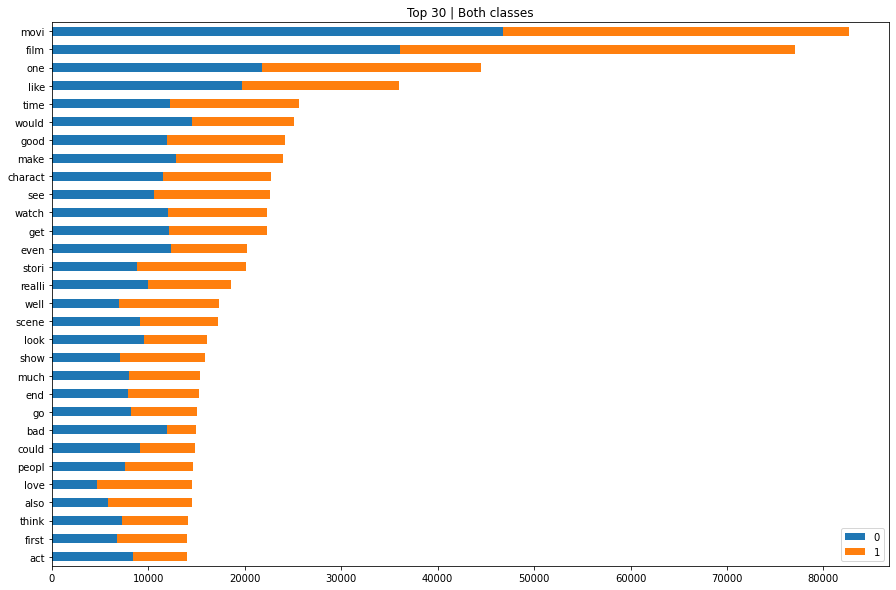

In [ ]:
top60_by_neg = freq.iloc[:60]
top30 = top60_by_neg.loc[(top60_by_neg[0] + top60_by_neg[1]).sort_values().index][30:]
top30.plot.barh(figsize=(15, 10), stacked=True)
plt.title('Top 30 | Both classes')
plt.show()

Now we can see that the word 'bad' is more common among negative reviews and words 'love' and 'well' are more common among positive ones.

#Words importance

In my opinion, the most important words are the words that are quite popular and have the biggest difference between appearing in negative and positive classes. That's why first I'll take top 1000 most frequent words and then sort them by percentage ratio of positive class to negative.

In [ ]:
top1000 = freq.iloc[:1000]
top1000["cmp"] = (top1000[1] / top1000[0] * 100)
top1000.sort_values(by="cmp", inplace=True, ascending=False)
top1000.head(10)

,0,1,cmp
excel,643.0,2904.0,451.632970
perfect,592.0,2161.0,365.033784
brilliant,431.0,1495.0,346.867749
favorit,511.0,1671.0,327.005871
amaz,599.0,1847.0,308.347245
highli,474.0,1373.0,289.662447
beauti,1332.0,3847.0,288.813814
today,543.0,1510.0,278.084715
touch,527.0,1458.0,276.660342
strong,488.0,1218.0,249.590164


Now we see that the most important words for a positive class are: 'excel', 'perfect', 'brilliant', 'favorit', 'amaz', etc.

Let's take a look at the most important words for a negative class.

In [ ]:
top1000.sort_values(by="cmp", ascending=True).head(10)

,0,1,cmp
wast,3217.0,282.0,8.765931
worst,3917.0,375.0,9.573653
poorli,1016.0,102.0,10.039370
aw,2638.0,279.0,10.576194
laughabl,722.0,77.0,10.664820
pointless,698.0,91.0,13.037249
lame,985.0,137.0,13.908629
pathet,734.0,108.0,14.713896
garbag,656.0,98.0,14.939024
horribl,2031.0,342.0,16.838996


Well, that's more like it.

I'd like to exclude from X datasets words that have a close number of occurrences in both classes and form "reduced" datasets.

In [ ]:
top = freq
top["cmp"] = (top[1] / top[0] * 100)
words_to_exclude = top[(top['cmp'] > 85) & (top['cmp'] < 115)]
words_to_exclude

,0,1,cmp
film,36087.0,40915.0,113.378779
one,21776.0,22685.0,104.174320
make,12919.0,11002.0,85.161390
time,12271.0,13324.0,108.581208
watch,12015.0,10318.0,85.875988
...,...,...,...
jape,1.0,1.0,100.000000
calder,1.0,1.0,100.000000
characatur,1.0,1.0,100.000000
piazza,1.0,1.0,100.000000


In [ ]:
words_to_exclude_set=set(words_to_exclude.index)

#Applying the function of removing stopwords
X_train_reduced=X_train.apply(remove_stopwords, stop=words_to_exclude_set)
X_test_reduced=X_test.apply(remove_stopwords, stop=words_to_exclude_set)

#Models

Now we can move on to the models. I'll use `CountVectorizer` to convert a text data to a matrix of token counts. Then I'll use `TfidfTransformer` to transform a count matrix to a tf-idf representation. The goal is to reduce the impact of tokens that are very common in a corpus and therefore less informative than features that occur in a small part of the corpus.

For each model, I'll perform `GridSearchCV` to find the best parameters. As a cross-validation splitting strategy, I'll use `StratifiedKFold` with 5 folds to ensure that the cross-validation result is a close approximation of generalization error. As a scorer, I'll use `roc_auc_score` since the dataset is balanced. To visualize the tradeoff between true positive rate and false positive rate, `RocCurveDisplay` will be used.

In [ ]:
def build_model(model, gs_params, X_train, y_train, X_test, y_test):
  pipe = Pipeline([
    ('vector', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('model', model())
  ])

  # Grid Search
  grid = GridSearchCV(pipe, param_grid=gs_params, scoring=make_scorer(roc_auc_score), cv=5, refit=True)
  grid.fit(X_train, y_train)

  print("Best score: ", grid.best_score_)
  print("Best parameters", grid.best_params_)

  # ROC-curve plotting
  rfc_disp = RocCurveDisplay.from_estimator(grid.best_estimator_, X_test, y_test)
  plt.show()

  return grid.best_estimator_

##NB

The first model is `MultinomialNB`.

Best score:  0.858725
Best parameters {'model__alpha': 0.7}


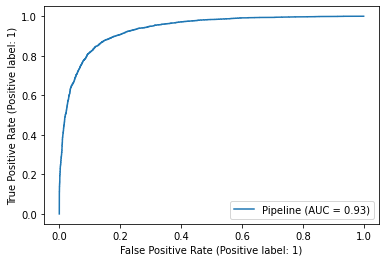

CPU times: user 3min 51s, sys: 766 ms, total: 3min 52s
Wall time: 3min 53s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', MultinomialNB(alpha=0.7))])

In [ ]:
%%time

parameters_nb = {
    'model__alpha': [1, 0.7, 0.4, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.03, 0.01]
}

build_model(MultinomialNB, parameters_nb, X_train, y_train, X_test, y_test)

The average of all cv folds is $0.8587$. AUC on test data is $0.93$.

Execution time is 3min 53s. There were 11 combinations in Grid search so we'll calcucate the time of one combination as 3 min 53 s / 11 = $21.18 s$.

Now I'd like to try this model on reduced datasets.

Best score:  0.8644499999999999
Best parameters {'model__alpha': 0.7}


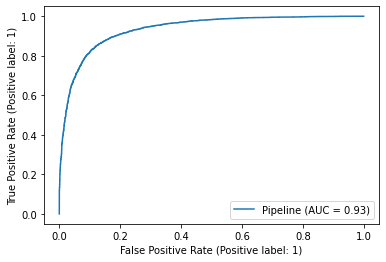

CPU times: user 2min 52s, sys: 562 ms, total: 2min 53s
Wall time: 3min


In [ ]:
%%time

est = build_model(MultinomialNB, parameters_nb, X_train_reduced, y_train, X_test_reduced, y_test)

The average of all cv folds is $0.8645$ (profit 0.006 compared to the model on the full dataset). AUC on test data is still $0.93$.

Execution time is 3min (profit 22.75% compared to the model on the full dataset). There were 11 combinations in Grid search so we'll calcucate the time of one combination as 3min / 11 = $16.36 s$.

##SGD

The second model is `SGDClassifier`.

I'll try it on the full dataset.

Best score:  0.8920999999999999
Best parameters {'model__alpha': 0.0001, 'model__loss': 'modified_huber', 'model__penalty': 'l2'}


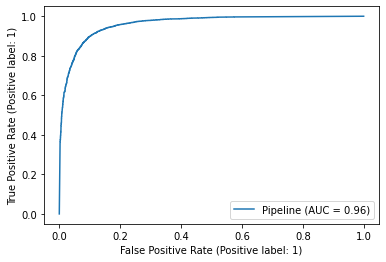

CPU times: user 24min 24s, sys: 27.1 s, total: 24min 51s
Wall time: 24min 59s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(loss='modified_huber'))])

In [ ]:
%%time

parameters_sgd = {
    "model__loss" : ["hinge", "log", "squared_hinge", "modified_huber"],
    "model__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "model__penalty" : ["l2", "l1", "none"],
}

build_model(SGDClassifier, parameters_sgd, X_train, y_train, X_test, y_test)

The average of all cv folds is $0.892$. AUC on test data is $0.96$.

Execution time is 24min 59s. There were $4*4*3=48$ combinations in Grid search so we'll calcucate the time of one combination as 24min 59s / 48 = $31.23 s$.

Now let's try this model on reduced datasets.

Best score:  0.89255
Best parameters {'model__alpha': 0.0001, 'model__loss': 'modified_huber', 'model__penalty': 'l2'}


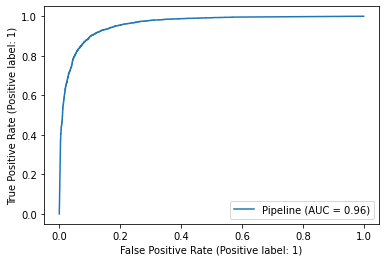

CPU times: user 17min 27s, sys: 26 s, total: 17min 53s
Wall time: 17min 46s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(loss='modified_huber'))])

In [ ]:
%%time

build_model(SGDClassifier, parameters_sgd, X_train_reduced, y_train, X_test_reduced, y_test)

The average of all cv folds is $0.8926$ (profit 0.006 compared to the model on the full dataset). AUC on test data is still $0.96$.

Execution time is 17min 46s (profit 28.89% compared to the model on the full dataset). There were 48 combinations in Grid search so we'll calcucate the time of one combination as 17min 46s / 48 = $22.21 s$.

So, `SGDClassifier` seems to be more accurate compared to `MultinomialNB` but at the same time it's more time-consuming.

##SVM

###LinearSVC

The next model is `LinearSVC`.

Best score:  0.8907
Best parameters {'model__C': 1, 'model__loss': 'hinge', 'model__penalty': 'l2'}


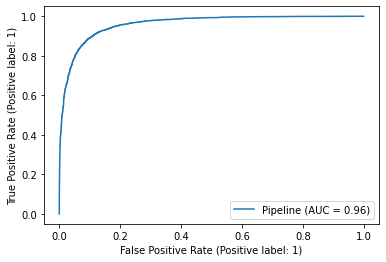

CPU times: user 16min 47s, sys: 3.14 s, total: 16min 51s
Wall time: 17min 10s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LinearSVC(C=1, loss='hinge'))])

In [ ]:
%%time

parameters_lin_svc = {
    'model__C': [0.1,1, 10, 100],
    'model__loss': ["hinge", "log", "squared_hinge", "modified_huber"],
    'model__penalty': ["l2", "l1", "none"],
}

build_model(LinearSVC, parameters_lin_svc, X_train, y_train, X_test, y_test)

The average of all cv folds is $0.89$. AUC on test data is $0.96$.

Execution time is 17min 10s. There were $4*4*3=48$ combinations in Grid search so we'll calcucate the time of one combination as 17min 10s / 48 = $21.46 s$.

Now let's try this model on reduced datasets.

Best score:  0.890375
Best parameters {'model__C': 1, 'model__loss': 'hinge', 'model__penalty': 'l2'}


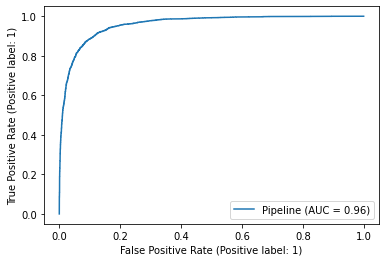

CPU times: user 11min 56s, sys: 2.24 s, total: 11min 59s
Wall time: 12min 16s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', LinearSVC(C=1, loss='hinge'))])

In [ ]:
%%time

build_model(LinearSVC, parameters_lin_svc, X_train_reduced, y_train, X_test_reduced, y_test)

The average of all cv folds is $0.8904$ (no positive profit compared to the model on the full dataset). AUC on test data is still $0.96$.

Execution time is 12min 16s (profit 28.54% compared to the model on the full dataset). There were 48 combinations in Grid search so we'll calcucate the time of one combination as 12min 16s / 48 = $15.33 s$.

So, `LinearSVC`, like `SGDClassifier`, seems to be more accurate than `MultinomialNB` and more time-consuming.

There is an insignificant difference (0.0003) between `SGDClassifier` and `LinearSVC` scores in favor of `SGDClassifier`. `LinearSVC` is faster than `SGDClassifier` and has ~30% time advantage.

###SVC

`SVC` is really time-consuming classifier so I couldn't manage to feel its full power trying different parameters. I set the maximum number of iterations as 3700.

Best score:  0.8843500000000001
Best parameters {'model__max_iter': 3700}


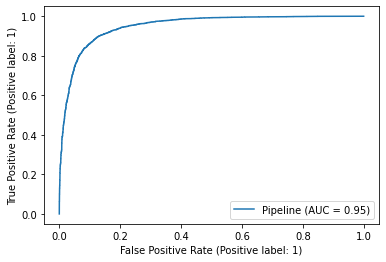

CPU times: user 23min 32s, sys: 1.83 s, total: 23min 34s
Wall time: 24min 10s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', SVC(max_iter=3700))])

In [ ]:
%%time

parameters_svc = {
    'model__max_iter': [3700],
}

build_model(SVC, parameters_svc, X_train_reduced, y_train, X_test_reduced, y_test)

The average of all cv folds is $0.884$ - less than the scores of the previous two models. AUC on test data is $0.95$.

Execution time is 24min 10s - the time of one combination.

Then I set the maximum number of iterations as 7000.

Best score:  0.8934749999999999
Best parameters {'model__max_iter': 7000}


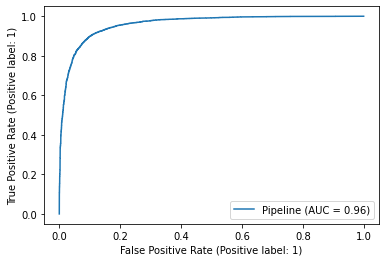

CPU times: user 45min 10s, sys: 2.82 s, total: 45min 13s
Wall time: 45min 14s


Pipeline(steps=[('vector', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('model', SVC(max_iter=7000))])

In [ ]:
%%time

parameters_svc = {
    'model__max_iter': [7000],
}

build_model(SVC, parameters_svc, X_train_reduced, y_train, X_test_reduced, y_test)

The average of all cv folds is $0.8935$ - a little bigger than the scores of the previous two models. AUC on test data is $0.96$.

Execution time is 45min 14s - the time of one combination.

#Conclusions

I observed four models: `MultinomialNB`, `SGDClassifier`, `LinearSVC` and `SVC`. The fastest model among the presented was `MultinomialNB`. At the same time, it gives the lowest score. The score difference between `SGDClassifier` and `LinearSVC` is insignificant but `LinearSVC` takes less time. `SVC` has chances to give good results but it is the slowest algorithm compared to others. As for this task, I'd prefer using `LinearSVC`.

Also, reducing the number of features seems to speed up the training of the models without loss of quality.

Possible improvements:

- More thorough text cleaning. Text may contain typos or slang, for example, and it could be considered.
- Taking into account the specifics of the subject area.
- Trying to use TextBlob. For example, considering feature analysis in groups, considering Part of Speech tags.
- Parallelization of operations.